# 중고나라 휴대폰 거래가격 예측하기
예제에서 사용하는 데이터는 https://www.data.go.kr/에서 제공하는 '네이버 중고나라'데이터, 그리고 통신 3사(SK Telecom. LG U+, kt olleh) 사이트에서 제공하는 휴대폰 공시가격 데이터를 기반으로 만들어진 것입니다.

## Step 1 탐색적 분석: 중고나라 데이터 분석하기
예제에서 사용할 중고나라 데이터셋은 다음과 같은 피처로 구성되어 있습니다.
- create_date: 판매(혹은 구매) 게시글이 올라온 시점
- price: 게시글 작성자가 제안한 휴대폰의 거래가격
- text: 게시글의 제목과 본문을 합친 텍스트 데이터
- phone_model: 휴대폰의 기종
- factory_price: 휴대폰 공시가격
- maker: 휴대폰 제조사
- price_index: 판매 게시글이 올라온 시점에서의 휴대폰 물가 지수 데이터

아래의 코드를 통해 데이터를 살펴본 결과, 약 5000여 개의 데이터가 결측값 없이 구성되어 있다는 것을 알 수 있습니다.
#### 중고나라 데이터셋 살펴보기

In [66]:
# -*- coding: utf-8 -*-
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/used_mobile_phone.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   create_date    4951 non-null   object 
 1   price          4951 non-null   float64
 2   text           4951 non-null   object 
 3   phone_model    4951 non-null   object 
 4   factory_price  4951 non-null   int64  
 5   maker          4951 non-null   object 
 6   price_index    4951 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 270.9+ KB
None


,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59


다음으로 개별 피처들을 탐색합니다.
#### 개별 피처 탐색하기: data 피처 탐색

In [67]:
#  create_date로 부터 '월'을 의미하는 mnth 정보를 피처로 추출합니다.
df['month'] = df['create_date'].apply(lambda x: x[:7])

# 월별 거래 횟수를 계산하여 출력합니다.
df['month'].value_counts()

2016-10    2956
2017-03    1311
2016-08     107
2016-09     105
2016-04     102
2016-05      89
2016-06      76
2016-07      74
2016-03      70
2016-02      61
Name: month, dtype: int64

date 피처에서 월별 게시글의 게시글의 개수를 살펴본 결과, 이 데이터는 2016년 10월, 그리고 2017년 3월에 집중적으로 수집된 데이터라는 것을 알 수 있습니다. <br>
데이터의 개수를 일자별 시계열 그래프로도 나타내보았습니다. 이는 아래의 그래프와 같습니다.

#### 개별 피처 탐색하기: date 피처 탐색

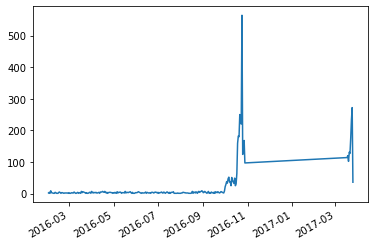

In [68]:
# 일별 거래 횟수를 계산하여 그래프로 출력합니다.
df_day = pd.to_datetime(df['create_date'].apply(lambda x: x[:10])).value_counts()
df_day.plot()
plt.show()

그리고 아래와 같이 price 피처의 탐색을 통해 중고나라에서 거래되고 있는 중고 휴대폰의 가격이 어느 정도인지 살펴볼 수 있습니다. 그래프로 분포를 살펴보면, 대부분의 중고 휴대폰이 60만 원 이하의 가격대를 형성하고 있으며, 몇몇은 그 이상에도 거래되고 있는 것을 알 수 있습니다.

#### 개별 피처 탐색하기: price 피처 탐색

<AxesSubplot:>

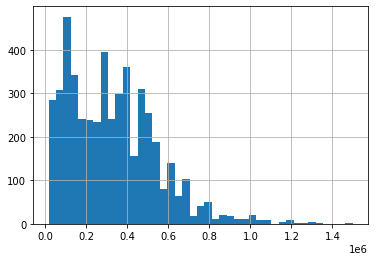

In [69]:
# 가격의 분포를 그래프로 탐색합니다.
df['price'].hist(bins="auto")

이번에는 휴대폰의 동일 기종 내에서의 가격 분포를 살펴봅시다. 이를 위해 phone_model을 groupby하여 그룹별 평균값과 표준편차를 구한 뒤, 모든  price의 z-score를 계산하였습니다. 이값은 '동일 기종'내에서의 상대적 가격을 나타내는 값입니다.

#### 개별 피처 탐색하기: price 피처 탐색

<AxesSubplot:>

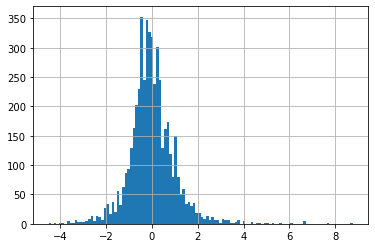

In [70]:
# 휴대폰 기종(phone_model)별 가격의 평균과 표준편차를 계산합니다.
df_price_model_mean = df.groupby('phone_model')['price'].transform(lambda x: np.mean(x))
df_price_model_std = df.groupby('phone_model')['price'].transform(lambda x: np.std(x))

# 이를 바탕으로 모든 데이터의 z-score를 계산합니다. 이는 해당 데이터의 가격이 기종별 평균에 비해 어느 정도로 높거나 낮은지를 알 수 있게 하는 점수입니다.
df_price_model_z_score = (df['price'] - df_price_model_mean) / df_price_model_std
df_price_model_z_score.hist(bins="auto")

이를 그래프로 출력한 결과,  동일 기종 내에서 price 피처의 분포는 정규분포에 가깝다는 것을 알 수 있습니다. <br>
이번에는 factory_price 피처의 분포, 그리고 factory_price와 price 간의 관계를 탐색해봅시다.

#### 개별 피처 탐색하기: factory_price 피처 탐색

<AxesSubplot:xlabel='factory_price', ylabel='price'>

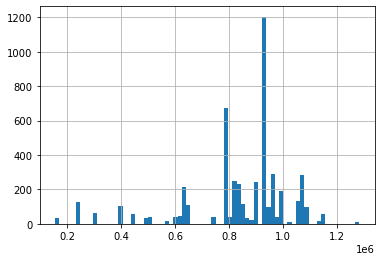

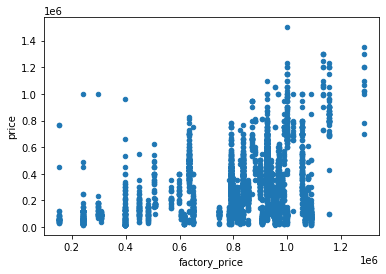

In [71]:
# factory_price 피처의 분포를 탐색합니다
df['factory_price'].hist(bins="auto")
   
# factory_price와 price 피처를 산점도 그래프로 출력하여 상관 관계를 살펴봅시다.
df.plot.scatter(x='factory_price', y='price')

위 그래프의 출력 결과, 두 피처는 양의 상관 관계를 가지고 있습니다. 이를 통해 factory_price는 중고 휴대폰 판매 가격에 꽤 중요한 영향을 미칠 것이라고 추정할 수 있습니다.<br>
다음으로 phone_model 피처를 탐색한 결과, 휴대폰 기종의 개수는 총 64대로 나타났습니다. 상위 5개의 기종을 제외하면 대부분 10개~90개 사이의 데이터를 가지고 있다는 것을 알 수 있습니다. 

#### 개별 피처 탐색하기 : phone_model 피처 탐색

count      64.000000
mean       77.359375
std       143.432786
min        10.000000
25%        23.000000
50%        35.000000
75%        90.500000
max      1002.000000
Name: phone_model, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x7f9bc28e8700>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9bc2566700>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9bc28e8a30>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9bc2566c70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9bc2566280>],
 'means': []}

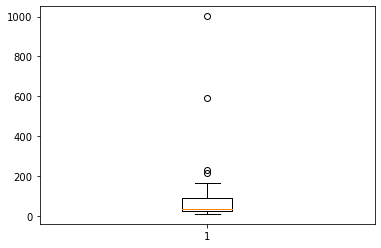

In [72]:
# 기종별 총 거래 데이터 개수를 집꼐합니다.
model_counts = df['phone_model'].value_counts()
print(model_counts.describe())

# 기종별 총 거래 데이터 개수를 상자 그림으로 살펴봅니다.
plt.boxplot(model_counts)

지금까지 탐색한 피처를 바탕으로 가격 예측 모델을 학습해봅시다. 그 과정에서 도출되는 피처 중요도 분석을 통해 어떤 피처가 예측 모델에 중요한 피처인지를 알 수 있습니다. 이러한 분석은 랜덤 포레스트라는 모델로 수행할 수 있습니다.

### 여기서 잠깐
랜덤 포레스트 모델 chapter04에서 살펴보았던 의사결정 나무분석 방법을 응용한 것으로 의사 결정 나무를 여러 개 모아 하나의 숲을 구성하는 방법입니다. 하나의 모델이 정답을 푸는 것이 아닌, 여러 개의 모델이 정답을 함께 푸는 것이기 때문에 더 정확한 학습이 가능합니다. 또한 이 방법은 모델이 생성되는 과정에서의 피처 중됴도를 계산하기 떄문에 탐색적 데이터 분석에 자주 사용됩니다. 랜덤 포레스트 모델은 회귀와 분류, 두 가지에 모두 적용이 가능합니다.

램덤 포레스트 sklearn 라이브러리의 RandomForestRegressor 클래스로 사용 가능합니다. 이 클래스의 fit 함수를 실행하여 모델을 학습한 뒤, feature_importances_를 출력하면 피처 중요도를 출력할 수 있습니다. 아래의 실행 결과는 모델의 예측 평가 점수인 R2 score, RMSE를 나타낸 것입니다. Train score와 Test score의 차이가 심한 것을 미루어 볼 때, 이 예측 모델은 과적합이 일어났다고 할 수 있습니다.

#### Random forest regressor를 이용한 가격 예측

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 데이터를 학습/테스트용 데이터로 분립합니다.
df = df[['price', 'phone_model','factory_price','maker','price_index','month']]
df = pd.get_dummies(df,columns=['phone_model','maker','month'])
X = df.loc[:,df.columns !='price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

# 랜덤 포레스트 모델을 학습합니다.
forest = RandomForestRegressor(n_estimators=1000, criterion='mse')
forest.fit(X_train,y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# 학습한 모델을 평가합니다.
print('MSE train:%.3f, test:%.3f' % (mean_squared_error(y_train, y_train_pred),
                                    mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),r2_score(y_test, y_test_pred)))

MSE train:10633822708.364, test:13880690849.515
R^2 train: 0.781, test: 0.683


아래의 코드와 실행 결과는 랜덤 포레스트 모델의 피처 중요도를 출력한 것입니다. 이를 통해 factory_price, maker_apple... 순으로 모델에 중요한 피처라는 것을 알 수 있습니다.

#### 피처 중요도 분석하기

[('factory_price', 0.40587475260568695),
 ('maker_apple', 0.2973776140381193),
 ('phone_model_galaxy s3 3g 8gb', 0.0221099692400612),
 ('phone_model_iphone se 64gb', 0.021487314693367954),
 ('price_index', 0.02084709902438816),
 ('phone_model_galaxy s4 32gb', 0.01650335588070174),
 ('month_2017-03', 0.014960118497103742),
 ('maker_samsung', 0.014188015890214914),
 ('phone_model_galaxy s6 32gb', 0.012396397739620804),
 ('month_2016-05', 0.010893565057665576)]

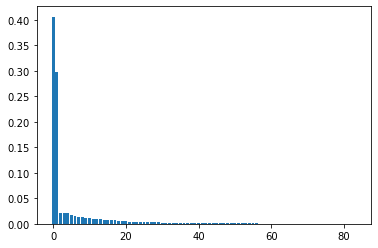

In [74]:
# 학습한 모델의 피처 중요도를 그래프로 살펴봅니다.
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

# 학습한 모델의 피처 중요도를 출력합니다.
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

그렇다면 '시간'은 모델에 어떤 영향을 미칠까요? 이를 알아보기 위해 month 피처의 중요도만 살펴봅시다.

#### 피처 중요도 분석하기

In [75]:
# month 피처 중, 영향력이 높은순으로 정렬하여 출력합니다.
for sorted_feature in sorted(feature, key=lambda tup: tup[1], reverse=True):
    if "month" in sorted_feature[0]:
        print(sorted_feature)

('month_2017-03', 0.014960118497103742)
('month_2016-05', 0.010893565057665576)
('month_2016-09', 0.008087982473426318)
('month_2016-04', 0.007600863634448296)
('month_2016-10', 0.006415482531650434)
('month_2016-06', 0.004420731651827199)
('month_2016-08', 0.0036828202171414665)
('month_2016-07', 0.0026707842346616116)
('month_2016-03', 0.0024066057223718147)
('month_2016-02', 0.0009666417569352028)


위 코드의 실행 결과를 살펴보면'최근'에 가까운 'month'일수록 피처의 중요도가 높은 것을 알 수 있습니다.

## Step 2 피처 엔지니어링: 예측 모델 개선하기
지금까지 수행한 탐색적 데이터 분석의 내용은 아래의 표와 같습니다. 이 내용을 토대로 가격 예측 모델의 성능을 개선하기 위한 피처 엔지니어링을 적용해봅시다.<br>
- 피처 - 분석내용 - 파생 가능한 피처
- date - 월 단위로 살펴본 결과, 2016년 10월과 2017년 3월의 데이터가 가장 많습니다. 최근에 가까운 월(Month)일수록 예측 모델에 중요한 피처입니다. - 게시글의 등록 월(Month)
- price - 전체 휴대폰의 거래가와 달리 기종별 가격의 분포는 정규 분포의 형태를 띠고 있습니다 - 동일 기종 내 상대 가격(z-score)
- factory_price - price 피처와의 양의 상관 관계가 관찰됩니다. 또한 예측 모델의 피처 중요도 분석 결과, 가장 중요한 피처로 나타났습니다.
- phone_model - 소수의 인기 기종이 많은 데이터를 가지고 있습니다. - 휴대폰 세부 기종, 용량으로 분리한 2개의 피처 
- maker - Apple 브랜드가 가장 많으며, 가격 예측에서도 Apple 브랜드 여부는 가장 중요한 피처 중 하나입니다.
- price_index - 월별 변동이 크지 않으며, 총 4개의 값만을 가지고 있습니다. 가격 예측에서 그다지 중요한 피처는 아닙니다.

가장 먼저 create_date 피처를 분석에 활용하기 위해 '시간 점수'라는 것을 만들어봅시다. 생성 과정은 다음과 같습니다.
- (1) create_date를 unixtime으로 변환합니다. unixtime은 시간을 정수로 표현한 것이며, 값이 클수록'최근'에 가까워집니다.
- (2) min-max 스케일링을 적용하여 unixtime을 상대적인 점수로 계산합니다.
- (3) 점수가 1에 가까울수록 최근에 작성한 게시물을 의미하며, 0에 가까울수록 오래된 게시물을 의미합니다.

#### 기존 피처 가공하기: 'create_date'

In [76]:
# 데이터를 다시 불러옵니다.
df = pd.read_csv("data/used_mobile_phone.csv")

from datetime import datetime
import time

# create_date 피처를 수치적으로 계산하기 위해 unixtime으로 변환하는 함수를 정의합니다.
def date_to_unixtime(date_str):
    timestamp = time.mktime(datetime.strptime(date_str, '%Y-%m-%d').timetuple())
    return timestamp

# create_date 피처를 '현재와 얼마나 가까운 데이터인지' 판단하기 위한 점수를 생성합니다. 먼저 unixtime으로 데이터를 변환합니다.
df['create_unixtime'] = df['create_date'].apply(lambda x: date_to_unixtime(x[:10]))

# 변환된 unixtime에 min-max 스케일링을 적용합니다.
df['create_time_score'] = (df['create_unixtime'] - df['create_unixtime'].min()) /\
                        (df['create_unixtime'].max() - df['create_unixtime'].min())
df[['create_date', 'create_unixtime','create_time_score']].head()

,create_date,create_unixtime,create_time_score
0,2017-03-19 4 35 00 PM,1.489882e+09,0.985612
1,2016-10-26 12 08 00 PM,1.477440e+09,0.640288
2,2016-10-25 12 52 00 PM,1.477354e+09,0.637890
3,2017-03-23 11 14 00 PM,1.490227e+09,0.995204
4,2016-04-11 7 35 00 PM,1.460333e+09,0.165468


다음으로 phone_model에 대한 피처 엔지니어링을 수행합니다. phone_model 피처는 '제품명+용량'으로 구성되어 있기 때문에 이를 나누어주기만 하면 2개의 분리된 피처를 얻을 수 있습니다. phone_model 피처를 분리하는 것은 어떤 효과가 있을까요?

#### 기존 피처의 가공: phone_model

In [77]:
# phone_model 피처에서 저장 용량(phone_model_storage) 피처를 추출합니다.
df['phone_model_storage'] = df['phone_model'].apply(lambda x: x.split(" ")[-1])

# phone_model 피처에서 기종 세부명(phone_model_detail) 피처를 추출합니다.
df['phone_model_detail'] = df['phone_model'].apply(lambda x: ''.join(x.split(" ")[:-1]))
df[['phone_model_storage','phone_model_detail']].head()

,phone_model_storage,phone_model_detail
0,64gb,iphone6
1,32gb,galaxys6edge
2,32gb,galaxys6
3,32gb,lgg5
4,32gb,lgu


아래 코드에서는 phone_model 피처를 분리함으로써 얻을 수 있는 효과를 알아보기 위해 피처 분리 이전과 이후의 분포를 상자 그림으로 비교해봅시다.

#### 기존 피처의 가공: phone_model

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9bc1517640>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9bc1517d00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9bc15172e0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f9bc1524400>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9bc1524760>,
 'means': []}

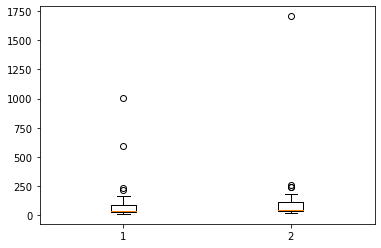

In [78]:
# phone_model 피처의 기종별 거래 데이터 개수를 집계합니다.
model_counts = df['phone_model'].value_counts()

# phone_model_datail 피처의 기종별 거래 데이터 개수를 집계합니다.
model_detail_counts = df['phone_model_detail'].value_counts()
data = [model_counts, model_detail_counts]

# 두 피처 간의 기종별 거래 데이터 개수를 비교합니다.
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.boxplot(data)

이를 살펴본 결과, 쏠림 현상이 심해진 하나의 기종을 제외하면 전체적인 분포가 안정적으로 변한것을 알 수 있습니다. 게다가 분석에 덤으로 사용할 수 있는 'phone_model_storage'라는 새로운 피처까지 생겼습니다<br>
이번에는 텍스트 정보에 대한 피처 엔지니어링을 수행합니다. 텍스트 정보에는 물품의 상태가 나타나 있을 것이고, 이는 가격 예측에 영향을 미칠 것이기 때문입니다. 따라서 물품의 상태를 분류할 수 있는 감성 분류가 필요합니다.<br>
그렇다면 감성 분류의 정답, 즉'상태가 좋다' 혹은'상태가 나쁘다'는 어떻게 판단할 수 있을까요? 이를 위해'기종별 가격의 분포는 정규분포다'라는 정보를 활용해 봅시다. 활용 방법은 다음과 같습니다.<br>
- (1) price 피처를 같은 기종 내에서의 z-score로 변환합니다.
- (2) z-score 기준, 상위 5%에 속하는 가격의 게시글은 '상태가 좋음',하위 5%는 '상태가 나쁨', 그리고 그 외는 '보통'으로 판단합니다. 상위n%의 판단은 quantile() 함수를 사용합니다.
- (3)정의한 세가지 상태를 감성 분류의 정답 데이터로 사용합니다.

####  감성 분류로 물픔의 상태 분류하기

-1.3966616903783426
1.666982156397844


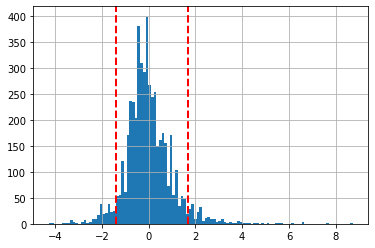

In [79]:
# 거래 가격(price)의 z-score를 계산합니다. 이는 해당 데이터의 가격이 기종의 평균에 비해 어느 정도로 높거나 낮은지를 알 수 있게 하는 점수입니다.
df['price_by_group'] = df.groupby('phone_model_detail')['price'].transform(lambda x:(x - x.mean()) / x.std())

# 거래 가격의 z-score(price_by_group)의 분포를 그래프로 출력합니다.
ax = df['price_by_group'].hist(bins="auto")

# z-score(price_by_group) 기준으로 하위 5%, 상위 5%에 해당하는 점수를 lower_bound, upper_bound라고 지정합니다.
lower_bound = df['price_by_group'].quantile(0.05)
upper_bound = df['price_by_group'].quantile(0.95)

# lower_bound, upper_bound 그래프에 추가합니다.
ax.axvline(x=lower_bound, color='r', linestyle='dashed', linewidth=2)
ax.axvline(x=upper_bound, color='r', linestyle='dashed', linewidth=2)

# lower_bound를 upper_bound 출렵합니다.
print(lower_bound)
print(upper_bound)

감성 분류의 정담 데이터를 'price_level'이라는 피처로 생성한 결과는 다음과 같습니다. 이제 우리는 price_level, 그리고 text피처를 이용하여 감성 분류를 수행할 수 있습니다.

#### 감성 분류로 물품의 상태 분류하기

In [80]:
# lower_bount보다 낮으면 0, upper_bound보다 높으면 2, 그 중간이면 1로 가격의 상태를 분류하는 함수를 정의합니다.
def get_price_level(price, lower, upper):
    if price <= lower:
        return "0"
    elif price >= upper:
        return "2"
    else:
        return "1"
# lower_bound 보다 낮으면 0, upper_bound보다 높으면 2, 그 중간이면 1로 가격의 상태를 분류합니다.
df['price_lower'] = df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.05))
df['price_upper'] = df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.95))
df['price_level'] = df.apply(lambda row: get_price_level(row['price'], row['price_lower'], row['price_upper']), axis=1)
df[['price','price_lower','price_upper','price_level','text']].head()

,price,price_lower,price_upper,price_level,text
0,550000.0,180000.0,680000.0,1,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...
1,380000.0,180000.0,414000.0,1,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...
2,300000.0,150000.0,349000.0,1,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...
3,290000.0,100000.0,500000.0,1,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...
4,280000.0,18000.0,400000.0,1,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...


다음으로 텍스트 전처리 과정을 진행할 차례입니다. 우선 실습 폴더에 있는 used_mobile_phone_stopwords.pkl 파일을 불러옵니다. 이파일은 중고나라 텍스트 분석에 사용되는 불용어를 미리 저장해놓은 파일입니다.

####  텍스트 전처리하기

In [81]:
import pickle
import re

# 중고나라 불용어 사전을 불러옵니다.
with open('data/used_mobile_phone_stopwords.pkl','rb') as f:
    stopwords = pickle.load(f)
    
# 불용어 사전에 등록된 단어 10개를 출력합니다
print(stopwords[:10])

['거래', '입니', '판매', '아이폰', '갤럭시', '골드', '팝', '만원', '폰', '시']


아래의 코드는 전처리된 데이터의 형태소를 추출하는 과정입니다.코드에서 정의된 함수 text_cleaning() 은 다음과 같은 전처리를 수행합니다.
- (1) 텍스트에서 특수문자를 제거합니다. 단,'+'와',' 문자는 제거하지 않습니다.
- (2) 텍스트에서 숫자를 제거합니다.<br>

또한 get_pos()는 불용어에 등장하지 않는 형태소만을 추출하여 반환하는 함수입니다.

출처 : "이것이 데이터 분석이다 with 파이썬"